# Fine-Tuning on Recorded Data

In [58]:
# Imports
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

import kerascnn2c
from pathlib import Path
import copy

In [59]:
def fixed_point_conversion(x: np.array, fixed_point: int):
  x /= 2**fixed_point
  return x

## Read Data

In [60]:
data_dir = '../../data/fine-tuning/fine-tune.pkl'

with open(data_dir, 'rb') as file:
    data = pickle.load(file)
file.close()

x = data['x']
y = data['y']

permutation = np.random.permutation(len(x))
x = x[permutation]
y = y[permutation]

min_int16 = fixed_point_conversion(-(2**15), 9)
max_int16 = fixed_point_conversion((2**15)-1, 9)

scaler = MinMaxScaler(feature_range=(min_int16, max_int16))

x = np.array([scaler.fit_transform(np.array(i).reshape((16000,1))) for i in x])

print(f'X shape: {x.shape}')
print(f'Y shape: {y.shape}')


X shape: (772, 16000, 1)
Y shape: (772, 5)


In [61]:
# splitting into training and validation data
train_split = int(0.8*len(x))

x_train, x_val = x[:train_split,:], x[train_split:,:]
y_train, y_val = y[:train_split,:], y[train_split:,:]

print(f'X train: {x_train.shape}')
print(f'X val: {x_val.shape}')
print(f'y train: {y_train.shape}')
print(f'y val: {y_val.shape}')

X train: (617, 16000, 1)
X val: (155, 16000, 1)
y train: (617, 5)
y val: (155, 5)


In [62]:
# Available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Name of Devices: ', tf.config.list_physical_devices())

Num GPUs Available:  1
Name of Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [63]:
# Create a basic model instance
checkpoint_path = '../models/test/pre-trained'


model = keras.models.load_model(checkpoint_path)

opt = tf.keras.optimizers.Adam(lr=10e-5, decay = 10e-6)
model.summary()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 1999, 8)           80        
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 499, 8)           0         
 g1D)                                                            
                                                                 
 conv1d_32 (Conv1D)          (None, 248, 16)           528       
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 62, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 30, 32)            1568      
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 7, 32)          

/opt/homebrew/Caskroom/miniforge/base/envs/embeddedAI/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x2f2f424a0>>

In [64]:
# Training model with GPU
with tf.device('/gpu:0'):
  history = model.fit(x_train, y_train, epochs=10, batch_size=2, validation_data=(x_val, y_val))

model.save('../models/test/fine-tuned')

Epoch 1/10


2023-04-30 15:47:10.484166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


309/309 [==============================] - ETA: 0s - loss: 4.7608 - categorical_accuracy: 0.2480

2023-04-30 15:47:14.965041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


309/309 [==============================] - 6s 16ms/step - loss: 4.7608 - categorical_accuracy: 0.2480 - val_loss: 4.1069 - val_categorical_accuracy: 0.2903
Epoch 2/10
309/309 [==============================] - 5s 15ms/step - loss: 3.3811 - categorical_accuracy: 0.2966 - val_loss: 3.6505 - val_categorical_accuracy: 0.2645
Epoch 3/10
309/309 [==============================] - 5s 15ms/step - loss: 2.8130 - categorical_accuracy: 0.3031 - val_loss: 2.9693 - val_categorical_accuracy: 0.3032
Epoch 4/10
309/309 [==============================] - 5s 15ms/step - loss: 2.3986 - categorical_accuracy: 0.3549 - val_loss: 2.7409 - val_categorical_accuracy: 0.2839
Epoch 5/10
309/309 [==============================] - 4s 14ms/step - loss: 2.1508 - categorical_accuracy: 0.3793 - val_loss: 2.5838 - val_categorical_accuracy: 0.2839
Epoch 6/10
309/309 [==============================] - 5s 15ms/step - loss: 1.9886 - categorical_accuracy: 0.3874 - val_loss: 2.3758 - val_categorical_accuracy: 0.3290
Epoch 7/1

INFO:tensorflow:Assets written to: ../models/test/fine-tuned/assets


INFO:tensorflow:Assets written to: ../models/test/fine-tuned/assets


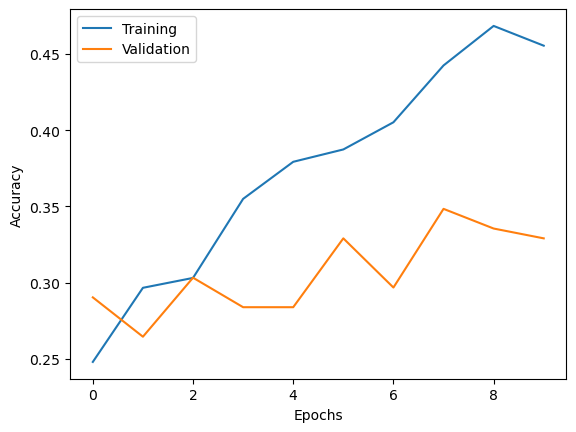

In [65]:
plt.plot(range(0, len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'])
plt.plot(range(0, len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training', 'Validation'])
plt.show()

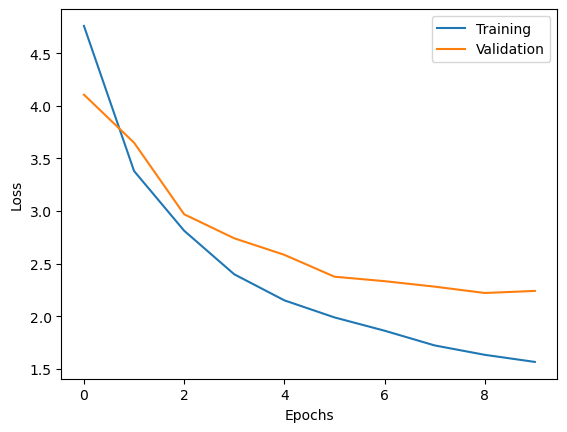

In [66]:
plt.plot(range(0, len(history.history['loss'])), history.history['loss'])
plt.plot(range(0, len(history.history['val_loss'])), history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training', 'Validation'])
plt.show()

In [67]:
with tf.device('/gpu:0'):
    model.evaluate(x_val, y_val, verbose=2)
    pred_test = model.predict(x_val)
    print(tf.math.confusion_matrix(y_val.argmax(axis=1), pred_test.argmax(axis=1)))

5/5 - 0s - loss: 2.2404 - categorical_accuracy: 0.3290 - 145ms/epoch - 29ms/step
5/5 [==============================] - 0s 14ms/step
tf.Tensor(
[[23  5  2  3  2]
 [ 6 17  7 13 10]
 [ 5 12  5  1 13]
 [ 3  6  0  3  4]
 [ 4  3  3  2  3]], shape=(5, 5), dtype=int32)


2023-04-30 15:47:58.790969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step


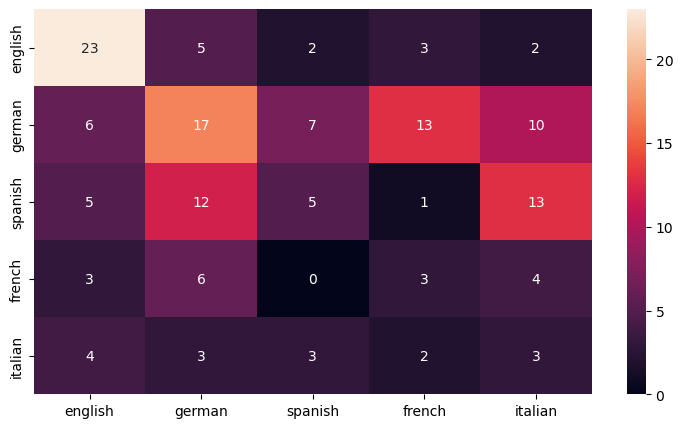

In [68]:
# Confusion matrix:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

CLASSES = ['english', 'german', 'spanish', 'french', 'italian']

preds = model.predict(x_val)
y_classes = preds.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_val.argmax(axis=-1), y_pred = y_classes)

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (9,5))
sn.heatmap(df_cm, annot=True, fmt = '.3g', xticklabels=CLASSES, yticklabels=CLASSES)
plt.show()

In [69]:
model.save('./keras2c/lab_gsc_no_globalavg.h5')

# remove softmax
model = tf.keras.Model(model.input, model.layers[-2].output, name=model.name)

In [70]:
FIXED_POINT=9
res = kerascnn2c.Converter(output_path=Path('keras2c/gsc_output_fixed'),
                           fixed_point=FIXED_POINT, # Number of bits for the fractional part, Q7.9 format
                           number_type='int16_t', # Data type for weights/activations (16 bits quantization)
                           long_number_type='int32_t', # Data type for intermediate results
                           number_min=-(2**15), # Minimum value for 16-bit signed integers
                           number_max=(2**15)-1 # Maximum value for 16-bit signed integers
                          ).convert_model(copy.deepcopy(model))
with open('keras2c/gsc_model_fixed.h', 'w') as f:
    f.write(res)

INFO:tensorflow:Assets written to: ram://b1e4abd4-981a-44cf-9815-3ff4bc6e39be/assets


INFO:tensorflow:Assets written to: ram://b1e4abd4-981a-44cf-9815-3ff4bc6e39be/assets


———————————————————————————————————————————————————————————————————————————————————————————————————————
Inputs                           | Layer                            | Outputs                         
———————————————————————————————————————————————————————————————————————————————————————————————————————
                                 | input_12                         | conv1d_31                       
-------------------------------------------------------------------------------------------------------
input_12                         | conv1d_31                        | max_pooling1d_24                
-------------------------------------------------------------------------------------------------------
conv1d_31                        | max_pooling1d_24                 | conv1d_32                       
-------------------------------------------------------------------------------------------------------
max_pooling1d_24                 | conv1d_32                        